In [1]:
# Imports
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

### **Bonus section** - **I**ts **J**ust **A** **L**inear **M**odel
The teaching of statistics, especially in psychology, is presented as a dazzling array of tools - a Swiss army knife of options that is typically overwhelming for new (and old) students. The typical practice involves a rote, algorithmic approach to statistical inference, whereby the confusion is somewhat reduced by selecting the appropriate test from the huge range on offer. The typical conversation goes like this:

- Do you want to compare two or more means? Four please!
- Do any of observations provide data in the different variables that make up the means? Yes they do!
- Actually, do *all* of the observatiins provide data in the different variables? No, only some.
- Then you need a mixed-factorial ANOVA. Wait, is that the same as a mixed model? 
- No. That's a form of regression. 
- So regression can't be used with groups? 
- It can.
- Oh no.

The problem with the algorithmic approach is, while it eases confusion initially (though I would argue that's not really the case) it masks the elegance of statistical inference from learners. In fact, the vast majority of classic statistical inference approaches used across quantitative science are forms of the steadfast ordinary least squares model. Really - everythig is a regression. To use the words of Professor Daniela Witten, its just a linear model (IJALM)!

Below I will walk through some examples of common statistical tests in psychology and express them as linear regressions using the `ols` function from `statsmodels`, also showing how the formula interface can be used to modify data in a model.

#### A t-test is regression
The difference between two groups is equivalent to a simple regression, with a single predictor - a predictor which codes which group the observation belongs to. What numbers you use don't matter, as long as they are different. Fortunately, `statsmodels` takes care of that for us if we use a formula - it is smart enough to recode the data! 

First lets look at a between-groups t-test using `pingouin` on the `tips` dataset, testing for differences in the amount of tips given by male and female patrons.

In [2]:
# Load tips
tips = sns.load_dataset('tips')

# Display result of t-test using pingouin, with no correction on unbalanced groups
pg.ttest(tips.loc[tips['sex'] == 'Female', 'tip'], 
         tips.loc[tips['sex'] == 'Male', 'tip'], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.38786,242,two-sided,0.166456,"[-0.62, 0.11]",0.185494,0.361,0.282179


In [3]:
# Now fit a linear model, predicting tip by sex
ttest_linear_mod = smf.ols('tip ~ sex', data=tips).fit()

# Show
ttest_linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.926
Date:                Thu, 23 Jun 2022   Prob (F-statistic):              0.166
Time:                        11:13:58   Log-Likelihood:                -423.98
No. Observations:                 244   AIC:                             852.0
Df Residuals:                     242   BIC:                             859.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0896      0.110     28.032      0.000       2.873       3.307
sex[T.Female]    -0.2562      0.185     -1.388      0.166      -0.620       0.107
==============================================================================
Omnibus:                       75.995   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.975
Skew:                           1.415   Prob(JB):                     4.59e-43
Kurtosis:                       6.342   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient of sex, contrasting male to female, has the same *t*-value as the result of a normal *t*-test. Let's take a moment to examine the intercept value - 3.096, and the coefficient value, -0.2562. If we compute the mean tip amount in our dataset by sex, we should find something interesting:

In [4]:
# Compute the mean tip per sex
means = tips.groupby('sex')['tip'].mean()
display(means)

# Now compute the difference between those means, using .diff of pandas, which subtracts row-wise
display(means.diff().round(4))

sex
Male      3.089618
Female    2.833448
Name: tip, dtype: float64

sex
Male         NaN
Female   -0.2562
Name: tip, dtype: float64

The coefficient represents the difference between going from the average of the male tip to the average of female tip. The intercept in the model is equal to the male tip mean!

#### A paired t-test as regression
A paired *t*-test asks whether the *difference* between two conditions, for the same observations providing the data, is statistically significant from zero. We demonstrate this equivlance by first carrying out a paired test, then computing the difference between conditions, and subjecting that variable to a one sample *t*-test. Let's load the `iris` dataset, which has measures on flower dimensions for different species, and look at the differences.

In [5]:
# Load iris from seaborn
iris = sns.load_dataset('iris')

# Compute paired t-test between sepal and petal length
normal_t = pg.ttest(iris['sepal_length'], iris['petal_length'], paired=True, correction=False)

# Work out the difference and submit to a one sample t-test, using the same function with 'zero' as second input
difference = iris['sepal_length'] - iris['petal_length']
one_sample = pg.ttest(difference, 0)

display(normal_t, one_sample)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,22.81322,149,two-sided,1.799629e-50,"[1.9, 2.27]",1.512468,1.018e+47,1.0


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,22.81322,149,two-sided,1.799629e-50,"[1.9, 2.27]",1.862692,1.018e+47,1.0


It should be no surprise that we can analyse this with a regression too. We want to predict the difference between two conditions using the mean of those differences. This will also allow us a demonstration of how, in formulas, you can use functions to alter your variables. 

In [6]:
# Set up the paired-test formula string
paired_formula = 'np.subtract(sepal_length, petal_length) ~ 1'

This formula allows us to call the `np.subtract` function, which subtracts two vectors, and predict it using the number one - this is regression speak for 'use the mean of the variable'!

In [7]:
# Regression
paired_regression = smf.ols(paired_formula, data=iris).fit()
paired_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     np.subtract(sepal_length, petal_length)   R-squared:                       0.000
Model:                                                 OLS   Adj. R-squared:                  0.000
Method:                                      Least Squares   F-statistic:                       nan
Date:                                     Thu, 23 Jun 2022   Prob (F-statistic):                nan
Time:                                             11:13:58   Log-Likelihood:                -229.28
No. Observations:                                      150   AIC:                             460.6
Df Residuals:                                          149   BIC:                             463.6
Df Model:                                                0                                         
Covariance Type:                                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0853      0.091     22.813      0.000       1.905       2.266
==============================================================================
Omnibus:                       68.329   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.580
Skew:                           0.469   Prob(JB):                     0.000682
Kurtosis:                       1.795   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The same! What is the mean difference?

In [8]:
difference.mean()

2.0853333333333333

#### A one-way ANOVA is regression
You may have heard that an ANOVA is a regression. This is true - IJALM - the predictors are simply variables that code which group the data belongs to. Let's examine the `exercise` dataset, which has several between-subjects variables. We will focus on the exercise `kind` variable - there are three groups of participants and each do a different exercise, where their pulse is measured.

First, we will analyse it using a simple one way ANOVA, and do follow up tests.

In [9]:
# Load exercise
exercise = sns.load_dataset('exercise')

# Anova for exercise data, where DV is pulse the the between subjects factor is exercise kind
anova = pg.anova(data=exercise, dv='pulse', between='kind')

# We will also compute the means to display
means = exercise.groupby('kind').agg({'pulse': 'mean'})

# Show
display(anova, means)

,Source,ddof1,ddof2,F,p-unc,np2
0,kind,2,87,31.987038,3.862193e-11,0.423742


,pulse
kind,
rest,90.833333
walking,95.200000
running,113.066667


Now, lets fit this as a ordinary least squares regression, to illustrate these tests are one and the same. All we need is to specify what we want to predict - pulse - and from what - exercise kind - and the model will take care of everything for us.

In [10]:
# Fit the model
reg_anova = smf.ols('pulse ~ kind', data=exercise).fit()

# Display the summary
reg_anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pulse   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     31.99
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           3.86e-11
Time:                        11:13:58   Log-Likelihood:                -345.27
No. Observations:                  90   AIC:                             696.5
Df Residuals:                      87   BIC:                             704.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          90.8333      2.083     43.610      0.000      86.693      94.973
kind[T.walking]     4.3667      2.946      1.482      0.142      -1.488      10.221
kind[T.running]    22.2333      2.946      7.548      0.000      16.379      28.088
==============================================================================
Omnibus:                        9.099   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.342
Skew:                           0.612   Prob(JB):                      0.00936
Kurtosis:                       3.996   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There are notable differences between the `pingouin` output and the OLS solution. First, the F statistic and effect size ($R^2$ for regression, partial $\eta^2$ for ANOVA) are identical. Its the same thing - IJALM explaining variance. But what to make of the coefficients? We have an intercept, and a 'walking' and 'running' coefficient. These coefficients represent the *mean difference* between, say, the walking condition, and the baseline (which here is implicitly *rest*). So if we add the intercept and the walking estimates together, we will get the mean of the walking condition. Try it! Notice that the intercept value is identical to the mean of the rest variable above. All the coefficients represent is moving from 'rest' to the other conditions. The significance tests help you interpret whether those differences are meaningful.

We can control what level goes into the intercept, too. We re-fit the model below and specify that 'walking' should be the baseline.

In [11]:
# Fit the model, but specify the baseline to be 'walking' by specifying a contrast like so
reg_anova = smf.ols('pulse ~ C(kind, Treatment(reference="walking"))', data=exercise).fit()

# Display the summary
reg_anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pulse   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     31.99
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           3.86e-11
Time:                        11:13:58   Log-Likelihood:                -345.27
No. Observations:                  90   AIC:                             696.5
Df Residuals:                      87   BIC:                             704.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             95.2000      2.083     45.707      0.000      91.060      99.340
C(kind, Treatment(reference="walking"))[T.rest]       -4.3667      2.946     -1.482      0.142     -10.221       1.488
C(kind, Treatment(reference="walking"))[T.running]    17.8667      2.946      6.066      0.000      12.012      23.721
==============================================================================
Omnibus:                        9.099   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.342
Skew:                           0.612   Prob(JB):                      0.00936
Kurtosis:                       3.996   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice now that the intercept the mean of walking, and to go to the 'rest' mean we need to subtract 4.3667 units. IJALM.

#### Factorial ANOVA's are also regressions
You guessed it - even more complex ANOVA designs can also be expressed as regressions, because the linear model approach underpins all of statistics. Interactions between one or more factors are also captured OLS. 

We can use the `anova_lm` function from statsmodels to show this is the case. This takes a regression model and computes an ANOVA from it. 

In [12]:
# Anova with Pingouin
aov = pg.anova(data=exercise, dv='pulse', between=['kind', 'diet'], 
               ss_type=1)
display(aov.round(3))

,Source,SS,DF,MS,F,p-unc,np2
0,kind,8326.067,2,4163.033,37.824,0.000,0.474
1,diet,1261.878,1,1261.878,11.465,0.001,0.120
2,kind * diet,815.756,2,407.878,3.706,0.029,0.081
3,Residual,9245.200,84,110.062,NaN,NaN,NaN


In [13]:
# Import the anova_lm function
from statsmodels.stats.anova import anova_lm

# Fit a model as a linear regression that includes both kind, diet, and their interaction
exercise_regression = smf.ols('pulse ~ kind + diet + kind:diet', exercise).fit()

# Conduct the anova
reg_anova = anova_lm(exercise_regression)
display(reg_anova.round(3))

,df,sum_sq,mean_sq,F,PR(>F)
kind,2.0,8326.067,4163.033,37.824,0.000
diet,1.0,1261.878,1261.878,11.465,0.001
kind:diet,2.0,815.756,407.878,3.706,0.029
Residual,84.0,9245.200,110.062,NaN,NaN


What `anova_lm` does is described in more detail below, but hopefully this has convinced you of the fact that statistics IJALM. When you get to working with repeated measures ANOVA or beyond you can switch to hierarchical models to account for the similarity between data points, and the principle is the same. When to use a the linear model or ANOVA approach? Both are the same, but both have their advantages. If you *only* have categorical predictors, an ANOVA is typically more straightforward to use. But if you want to blend categorical and continuous predictors, you can only extend into the linear model approach which will never let you down, once the interpretation is mastered. 

#### A deep dive into statistics - factorial ANOVA designs as linear models

With a little (a lot) effort, we can understand the equivalence of things like *t*-test and ANOVA by delving into the foundations of classical statistics, which seeks to explain the *variability* in response variable using other variables. 

What is variability anyway? Put simply, it is the amount a variable spreads out around its mean. For example, we can plot the `pulse` variable measured in the `exercise` dataset and examine its variability:

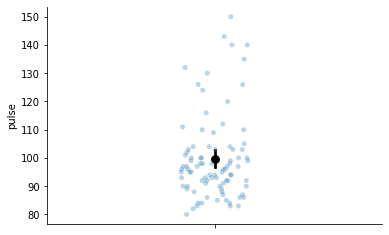

In [14]:
# Show variability of pulse, black dot is the mean
figure = sns.stripplot(data=exercise, y='pulse', alpha=0.3)
sns.pointplot(data=exercise, y='pulse', color='black', ax=figure)
sns.despine(ax=figure)

The variability is clear here. Lots of points are around the mean, with some further away. We can summarise this variability with a single number, which is **vital** in statistics - known as the *total sums of squares*. This number represents how variable a variable is! We compute the total sums of squares by:
1. Compute the mean of a variable
2. Subtracting the mean from each observation in a variable
3. Squaring those values
4. Adding them all up

As an aside, this sums of squares is the basis of the variance and standard deviation statistics. To get variance, divide the sums of squares by the number of datapoints, minus one. To get the standard deviation, take the square root of the variance.

Once we have this variability, we have another vital question - how can we *explain* this variability? Are there other variables that can account for this variability? As you have no doubt guessed, a linear model can do this. Lets see how. First we will compute the total sums of squares of the `pulse` variable.

In [15]:
# Compute pulse sums of squares
total_sums_squares = np.sum((exercise['pulse'] - exercise['pulse'].mean()) ** 2)
print(total_sums_squares)

19648.9


#### Measuring error and $R^2$
The implicit way in which almost all statistical tests progress is via a *model comparison*. If we were given the `pulse` variable, and asked to make a guess about what each observation would be, we could use the mean of `pulse`. How would we measure our accuracy, or put another way, how well would we quantify our error using this method? The approach is to take the difference between the actual data and the prediction, known as the **sums of squares residual**, because the 'residuals' are what is 'left over' after our guesses. We take the differences, square them, and add them up.

In fact, these two sums of squares - the total and residual - are what we need to compute the $R^2$, using a simple formula - $1 - \frac{SSR}{SST}$. This tells us the percentage of variation explained in a literal sense. 

We find an interesting equivalence here. If we use the mean of a variable as our best guess, then our sums of squares residual will be equal to the total sums of squares of a variable! We can fit a model using `statsmodels` and the `ols` class to demonstrate this. 

In [16]:
# Remember that a variable ~ 1 is equivalent to using the mean to predict a variable
base_model = smf.ols('pulse ~ 1', exercise).fit()

# The model has a 'ssr' attribute that holds our sums of squares residuals
print(base_model.ssr, base_model.ssr == total_sums_squares)

# And also has a 'centered_tss' attribute that stores its total sums of squares
print(base_model.centered_tss == total_sums_squares and base_model.centered_tss == base_model.ssr)

19648.9 True
True


We can now compute directly the $R^2$ of our model and compare it to the attribute stored by the model. In this case, the $R^2$ is zero, as we have explained no variability by using the mean as a guess.

In [17]:
# Manually compute
rsquared = 1 - (base_model.ssr / base_model.centered_tss)

# Check against the model
print(rsquared == base_model.rsquared)

True


Now we know that the mean of a variable can be thought of as a 'guess' for the variability of a model, lets try and do better. Someone's pulse is probably determined by the kind of activity they are doing. Luckily, we have this data, so lets add it as a predictor in a new model, and check the summary. This will tell us what the new $R^2$ is.

In [18]:
# Add 'kind' as a predictor
with_kind = smf.ols('pulse ~ 1 + kind', exercise).fit()
display(with_kind.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pulse   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     31.99
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           3.86e-11
Time:                        11:13:58   Log-Likelihood:                -345.27
No. Observations:                  90   AIC:                             696.5
Df Residuals:                      87   BIC:                             704.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          90.8333      2.083     43.610      0.000      86.693      94.973
kind[T.walking]     4.3667      2.946      1.482      0.142      -1.488      10.221
kind[T.running]    22.2333      2.946      7.548      0.000      16.379      28.088
==============================================================================
Omnibus:                        9.099   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.342
Skew:                           0.612   Prob(JB):                      0.00936
Kurtosis:                       3.996   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can assume from our large $R^2$ that our sums of squared residuals are lower, which we can confirm and check the $R^2$ manually. Our total sums of squares will be unchanged, as the `pulse` variable is the same.

In [19]:
# Show SSR and SST
print(f'SSR = {with_kind.ssr}\nSST = {with_kind.centered_tss}')

# Directly
rsquared = 1 - (with_kind.ssr/with_kind.centered_tss)

# Compute Rsquare directly
print(f'R squared = {rsquared}')

SSR = 11322.833333333332
SST = 19648.9
R squared = 0.42374212636161157


### How much better? A model comparison via differences in error
Our sums of squares residual has gone down - we have less error if we use exercise kind as a predictor. Great! But, how much should we care about this? Is this a meaningful change or not? How can we evaluate the usefulness of our predictors? The way to do this is by using a comparison of linear models, which gives us an $F$-ratio - you will have spotted these in the summary, but we can get this ourselves, by getting some key numbers from our model. 

What we do is take the error from our current model, and see how different it is from the previous model. We normalise that difference in error by the difference in the number of predictors between models. For example, if model A has a high error with three predictors, but model B has a very low error but with an additional 25 predictors, we may not be so impressed compared to the same lower error with a model with a single additional predictor. 

So how do we compare the usefulness of our predictors? We compare the sums of squares residuals of our mean only and sums of squares residuals of our current model, with `kind` as a predictor, to the mean-only model.

There are several steps involved:
1. Work out the difference between the residual sums of squares in the mean only model, and the current model. We can call this the ss-diff.
2. Get the SSR of the current model - this is the error we will compare against.
3. Get the residual degrees of freedom in the mean only model, and the current model. The residual degrees of freedom, though fancy-sounding, are represented by the number of observations, minus one, minus the number of predictors in a model. Work out the difference between these two values.
4. Normalise the SSR of the current model by the residual degrees of freedom, by division.
5. Then divide the ss-diff by the differences in the residual degrees of freedom between the models. These can be thought of as the mean squares difference in error by the mean squares error in the current model.
6. Dividing the resulting values gives your $F$ value which can be tested for significance.

That seems like a lot of work. Thankfully, the `anova_lm` function, when called with two arguments, will do all of this for us! Let's see how it performs with the `base_model` and the `with_kind` models.

In [20]:
anova_lm(base_model, with_kind)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,89.0,19648.900000,0.0,NaN,NaN,NaN
1,87.0,11322.833333,2.0,8326.066667,31.987038,3.862193e-11


This means the difference in $R^2$ - from zero to .42 when including `kind` is a significant result. We can also check this calculation manually:

In [21]:
# What is the difference in residual sums of squares in the models - how big is the difference in error?
ss_diff = with_kind.ssr - base_model.ssr

# What is the residual SS of the new model?
current_ssr = with_kind.ssr

# What is the difference in the residual degrees of freedom between models?
# ie - how many datapoints are 'left' over in both?
model_df_diff = with_kind.df_resid - base_model.df_resid

# What is the residual degrees of freedom in our new model?
# nobs - number of observations - its also in .df_resid!
resid_df = with_kind.nobs - 1 - with_kind.df_model

# Normalise our errors
mean_squares_error_difference = ss_diff/model_df_diff
mean_squares_error = current_ssr/resid_df

# Get F
F = mean_squares_error_difference/mean_squares_error

Now, we can check the F value matches the F value computed by our `with_kind` model, as this is what the model was doing to begin with to check the model fit!

In [22]:
F == with_kind.fvalue

True

#### What ANOVA does
When computing a factorial ANOVA, the analysis proceeds by building a stepwise model, examining the change in the amount of variance explained in each step, and computing the significance of it, moving from a model with no predictors to those with more. 

Let us fit our full model on the `exercise` data, with two predictors `kind` and `diet`, and their interaction, using a linear model, and the compute the ANOVA using `anova_lm`.

In [23]:
# Fit model
full_model = smf.ols('pulse ~ 1 + kind + diet + kind:diet', exercise).fit()

# Get ANOVA
anova = anova_lm(full_model)
display(anova.round(3))

,df,sum_sq,mean_sq,F,PR(>F)
kind,2.0,8326.067,4163.033,37.824,0.000
diet,1.0,1261.878,1261.878,11.465,0.001
kind:diet,2.0,815.756,407.878,3.706,0.029
Residual,84.0,9245.200,110.062,NaN,NaN


Here, the question is whether the 'full' model - the one containing both the predictors and their interaction - is a better fit to the data than the models that precede it. The key thing to rememeber is that the model with the interaction has all the predictors in it, while the 'diet' model has kind and diet, with no interaction, and the 'kind' model only has that predictor, and nothing else.

First, build all the component models.

In [24]:
# Build the separate step models
base_model = smf.ols('pulse ~ 1', exercise).fit()
kind = smf.ols('pulse ~ 1 + kind', exercise).fit()
kind_diet = smf.ols('pulse ~ 1 + kind + diet', exercise).fit()
full = smf.ols('pulse ~ 1 + kind + diet + kind:diet', exercise).fit()

We can now recreate the analysis of the ANOVA table by comparing models, using the error from the full model (the one with all the predictors and interaction in), and looking at the differences in sums of squares residual between the models, divided by their respective degrees of freedom. 

In [25]:
# First, get the mean-squared-error from the full model
mean_squared_error = full.mse_resid

# What is the effect of adding diet to the model, over and above kind?
diet_F = ((kind_diet.ssr - kind.ssr) / (kind_diet.df_resid - kind.df_resid)) / mean_squared_error

# Or, what about just kind on its own?
kind_F = ((kind.ssr - base_model.ssr) / (kind.df_resid - base_model.df_resid)) / mean_squared_error

In [26]:
# Show
display(anova.round(2))
print(round(diet_F, 2), round(kind_F, 2))

,df,sum_sq,mean_sq,F,PR(>F)
kind,2.0,8326.07,4163.03,37.82,0.00
diet,1.0,1261.88,1261.88,11.47,0.00
kind:diet,2.0,815.76,407.88,3.71,0.03
Residual,84.0,9245.20,110.06,NaN,NaN


11.47 37.82


Of course, the `anova_lm` function does this is all for you. If you wanted to see the differences in $R^2$ associated with these F tests - the actual effect of interest - we can compute them through simple subtraction of the model R square properties.

In [27]:
# Get R squared 
r_squared = {'kind': kind.rsquared - base_model.rsquared,
            'diet': kind_diet.rsquared - kind.rsquared,
            'kind:diet': full.rsquared - kind_diet.rsquared
            }
# Turn this to a series
r_sq = pd.Series(r_squared, index=anova.index, name='R2_change')

# Add to our anova table
full_anova = anova.join(r_sq)
display(full_anova.round(3))

,df,sum_sq,mean_sq,F,PR(>F),R2_change
kind,2.0,8326.067,4163.033,37.824,0.000,0.424
diet,1.0,1261.878,1261.878,11.465,0.001,0.064
kind:diet,2.0,815.756,407.878,3.706,0.029,0.042
Residual,84.0,9245.200,110.062,NaN,NaN,NaN


And if we compute the total $R^2$ from this table, it will be equal to the $R^2$ of the full regression model!

In [28]:
r2_sum = full_anova['R2_change'].sum()
print(r2_sum == full.rsquared)

True



Once you have arranged your data into a format that can be easily analysed, then computing a general range of statistical inferences is made easy by the range of packages in Python. The ability to use a single language to complete all analysis steps is a huge plus. The world of statistical inference is enormous and Python is extremely well supported for these kinds of analyses - explore online and the chances are there is a package out there to suit your needs!

Good luck in your data adventures with Python!